# Classification

**Task:** Classify all new clients into marketing segments based on the demographic data.

**Project use case:** Contract recommendation system supporting a company employee who presents an offer to a new client. 

For the portfolio project, the purpose of the classification task is to predict new client's segment. The predicition is done with ML model based on clients' demographic data, which client provides during first interview, eg. age or education level. It turned out to be a hard problem to solve, because the segments were created in *Clustering notebook* using only clients' behaviour statistics, such as months on book or transactions count change. 

The notebook consists of:
1. EDA of Segments
2. Sanity Model
3. Classifiers
4. Final Model
5. Summary

***

Import necessary libraries and download the data.

In [1]:
import pandas as pd
import numpy as np

# set the number of cores
n_jobs = 3

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [2]:
def getDataRepo(data='demographics'):
    """
    returns specified data from Repository as DataFrame
    Parameters:
    path - ['demographics', 'statistics' or 'segments']; default: 'demographics'
    """
    try:
        url = 'https://github.com/giastantino/PortfolioProject/blob/main/Notebooks/Data/' + data + '.csv?raw=True'
        client_df = pd.read_csv(url)
        print(data + ' data has been read')
        return client_df
    except Exception as e:
        print(e)

In [3]:
# read demographic data
demo_df = getDataRepo('demographics')

# read segments data
segment_df = getDataRepo('segments')

# create df for clients with known segment
client_df = demo_df.merge(segment_df, on='client_id')

# create df for clients with unknown segment
unknown_df = demo_df[~demo_df['client_id'].isin(segment_df['client_id'])].reset_index(drop=True)

demographics data has been read
segments data has been read


# EDA of Segments

In this notebook, we will try to predict customer segments based on demographics. To do this, we'll examine your data focusing on segments and how features define them.

As established in clustering notebook, there are four segmnets of clients: `bill_payer` `card_master` `barrel_scraper` and `golden_fish`.

## Features

What are the demographic features and how can they describe clients?

In [4]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8223 entries, 0 to 8222
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   client_id        8223 non-null   int64 
 1   age              8223 non-null   int64 
 2   gender           8223 non-null   object
 3   dependent_count  8223 non-null   int64 
 4   education_level  8223 non-null   object
 5   marital_status   8223 non-null   object
 6   income_category  8223 non-null   object
 7   segment          8223 non-null   object
dtypes: int64(3), object(5)
memory usage: 578.2+ KB


There are two numerical categories in the dataset. The remaining columns are categorical (mostly ordinal) data.

How are categorical features represented?

In [5]:
#print categorical data
def print_unique_values(df):
  for col in df.select_dtypes(include=['object']).columns:
    print(f'-> {col}({len(df[col].unique())}):  {df[col].unique()}')
    print(f'{df[col].value_counts()}\n'),

print_unique_values(client_df)

-> gender(2):  ['F' 'M']
F    4327
M    3896
Name: gender, dtype: int64

-> education_level(7):  ['High School' 'Uneducated' 'Unknown' 'College' 'Graduate' 'Post-Graduate'
 'Doctorate']
Graduate         2545
High School      1653
Unknown          1219
Uneducated       1214
College           838
Post-Graduate     407
Doctorate         347
Name: education_level, dtype: int64

-> marital_status(4):  ['Married' 'Single' 'Unknown' 'Divorced']
Married     3804
Single      3189
Divorced     617
Unknown      613
Name: marital_status, dtype: int64

-> income_category(6):  ['Less than $40K' 'Unknown' '$120K +' '$60K - $80K' '$40K - $60K'
 '$80K - $120K']
Less than $40K    2871
$40K - $60K       1466
$80K - $120K      1254
$60K - $80K       1161
Unknown            890
$120K +            581
Name: income_category, dtype: int64

-> segment(4):  ['golden_fish' 'bill_payer' 'barrel_scraper' 'card_master']
bill_payer        3044
card_master       2296
barrel_scraper    1731
golden_fish       1152
Name

Clients demographic information splits into 4 categorical categories: `gender`, `education_level`, `marital_status` and `income_category`. Futhermore there is column containing iformation about client's segment `segment`.

***

In [6]:
# describe numerical data
client_df.drop(['client_id'],axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
age,8223.0,46.161985,7.885725,26.0,41.0,46.0,52.0,73.0
dependent_count,8223.0,2.359115,1.294908,0.0,1.0,2.0,3.0,5.0


Above we can see that average age for cliets is 46 years and most of the clients are 41 to 52 years old. Most of the clients have from 1 to 3 dependants and mean for all the clients is above 2.

***

## Sample clients

To get better understanding of the customers and how the data transforms through the analysis, let's selecet a few data points (that are diffrent from each other) and explore them.

In [7]:
# selecting three indicises
indices = [22, 300, 2100]

# create a DataFrame of the chosen samples
samples = pd.DataFrame(client_df.loc[indices], columns = client_df.keys()).drop(['client_id'],axis=1).reset_index(drop=True)
print ("Chosen samples of the dataset:")
display(samples)

Chosen samples of the dataset:


,age,gender,dependent_count,education_level,marital_status,income_category,segment
0,46,M,5,Doctorate,Divorced,$120K +,golden_fish
1,46,F,4,College,Married,Unknown,bill_payer
2,41,F,2,Uneducated,Married,$40K - $60K,card_master


Those three clients are quite diffrent. Sample 0 is golden_fish with income over $120K. Sample 1 is married bill_payer after college with 4 dependents. Sample 2 is an uneducate female with two dependents and 40K-60K earning, she is a card_master.

***

## Representation of Segments

In [8]:
# get the cluster data
clust_er = segment_df.segment.value_counts()
labels = clust_er.index.to_list()
values = clust_er.values

# color theme
colors = ['#ED254E','#F9DC5C', '#16b27a', '#011936']

# draw pie chart
fig = go.Figure()
fig.add_trace(go.Pie(labels=labels, 
                     values=values,
                     name='Clusters',
                     pull=[0.01, 0.01, 0.01, 0.01] 
                     ))
fig.update_traces(textposition = 'inside', 
                  textinfo = 'percent + label',
                  hole = 0.65, 
                  marker = dict(colors = colors,
                                line = dict(color = 'gray', width = 1)),
                  hovertemplate = 'Clients: %{value}',
                  )
fig.update_layout(title_text="",
                  autosize=False,width=700,height=700,
                  annotations=[dict(text='Clients<br>by<br>Segments', 
                                    x=0.5, y=0.5, 
                                    font_size=26, 
                                    font_family = 'monospace',
                                    showarrow=False),
                               ]
                  )
fig.show()

There are four segmnets of clients: `bill_payer` 37%, `card_master` 27.9%, `barrel_scraper` 21.1% and `golden_fish` 14%. The most represented groups are bill payers and card masters, together they account for more then 60% of all clients.

***

**Q1:** How is each segment characterized in terms of client demographic data?

In [9]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import make_column_transformer

# column lists for polar chart
ordinal_columns = ['education_level', 'income_category', 'marital_status']
ordinal_categories = [['Unknown','Uneducated','High School', 'College','Graduate', 'Post-Graduate', 'Doctorate'],
                      ['Unknown', 'Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +'],
                      ['Unknown','Single','Married', 'Divorced']]
bin_columns = ['age']


#create encoder objects
oe = OrdinalEncoder(categories=ordinal_categories)
ohe = OneHotEncoder(sparse=False, drop='if_binary')
kbd = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='uniform')

#create column transformer
polar_enc = make_column_transformer((ohe, ['gender']),
                                    (kbd, ['age']),
                                    (oe, ordinal_columns),
                                    ('passthrough', ['dependent_count', 'segment']),
                                    remainder = 'drop'
                                   );

# fit the encoder
clusters_df = polar_enc.fit_transform(client_df);
clusters_df = pd.DataFrame(clusters_df, columns = ['gender','age','education_level', 'income_category','marital_status',
                                                   'dependent_count', 'segment'])

# average client of each segment vs average values of all the data
segments_info = np.round((clusters_df.groupby(['segment']).mean()-clusters_df.drop(['segment'],axis=1).min())
                         /(clusters_df.drop(['segment'],axis=1).max()-clusters_df.drop(['segment'],axis=1).min()),3).reset_index()

# data preparation
polar=pd.melt(segments_info, id_vars=['segment'])

# draw the polar graph
fig2 = px.line_polar(polar, r="value", theta="variable", color='segment',
                     color_discrete_map={'bill_payer':'#ED254E','card_master':'#F9DC5C',
                                         'barrel_scraper':'#16b27a','golden_fish':'#011936'},
                     line_close=True, height=600, width=800)

fig2.show()


The above chart has *no statistical* meaning, but its only purpose is to help the reader build an *intuition* about considered segments. Some insights gained:
* `card_master` group is vastly distinct from the rest when it comes to income_category and gender of clients
* `barrel_scraper` is slightly diffrent  when described by `marital_status` and `dependent_count`
* there is probably no feature that would make `golden_fish` segment stand out
* furthermore, there is no intuitive distincation between all segments on `education_level` and `age`

***

**Q2:** Why is `card_master` segment so distintict when it comes to gender and income? 

In [10]:
fig = px.histogram(client_df, 
                   x="segment", 
                   color="gender",
                   barmode = 'group',
                   color_discrete_map={'F':'#b366ff', 'M':'#3385ff'},
                   height=400, width=800
                  )

fig.update_layout(title = 'Segmets by gender',
                  xaxis_title= 'Segments',
                  yaxis_title= 'Representation',
                  legend_title= 'Gender:',
                  bargap=0.3)

fig.show()

>Segments `golden_fish`, `bill_payer` and `barrel_scraper` have more male representation then female, but the proportion is similar for each group. On the other hand, there is significant female over-representation in the `card_master` segment.

In [11]:
# plot the income vs segment graph 
fig = px.histogram(client_df, 
                   x="income_category", 
                   color="segment",
                   barmode = 'group',
                   category_orders=dict(income_category=['Unknown', 'Less than $40K','$40K - $60K', 
                                                         "$60K - $80K", '$80K - $120K', '$120K +']),
                   color_discrete_map={'bill_payer':'#ED254E','card_master':'#F9DC5C',
                                       'barrel_scraper':'#16b27a','golden_fish':'#011936'},
                   height=400, width=1000
                  )

fig.update_layout(title = 'Income Category by Segments',
                  xaxis_title= 'Income Category',
                  yaxis_title= 'Representation',
                  legend_title= 'Segments:',
                  bargap=0.25)

fig.show()

>The `card_master` segment has the biggest represenation in 'Less than 40K' `income_category`, the second biggest group of this segment's clients is in '40K to 60K' category. For the rest of the segments there is no visible diffrence in the clients distirbution between categories.

As we can see on above graphs the intuition from the polar chart turned out to have an interesting consequences in the data. The `card_master` segment is a group of predominantly female and the most of the clients are in 'Less than 40K' income category - therefore there is and extra question that can be asked: 

**Extra question:** What is the chance that randomly chosen female in 'less than 40K' income category is a `card_master`?

In [12]:
def get_40_f_chance(client_df):
    df = client_df[client_df['income_category']=='Less than $40K']
    card_master_40k_f = df[df['gender']=='F'].groupby(['segment']).size()['card_master']
    card_master_40k_all = df[df['gender']=='F'].groupby(['segment']).size().sum()
    return card_master_40k_f * 100/ card_master_40k_all

print(f'The chance of randomly chosing card_master from `less than 40k` category females equals: {get_40_f_chance(client_df):.2f}%')

The chance of randomly chosing card_master from `less than 40k` category females equals: 46.85%


***

**Q3:** What does `barrel_scraper` intuition on `marital_status` actually mean?

In [13]:
# plot the income vs segment graph 
fig = px.histogram(client_df, 
                   x="marital_status",
                   color="segment",
                   barmode = 'group',
                   color_discrete_map={'bill_payer':'#ED254E','card_master':'#F9DC5C',
                                       'barrel_scraper':'#16b27a','golden_fish':'#011936'},
                   height=400, width=1000
                  )

fig.update_layout(title = 'Marital Status by Segment',
                  xaxis_title= 'Marital Status',
                  yaxis_title= 'Representation',
                  legend_title= 'Segments:',
                  bargap=0.25)

fig.show()

In fact `barrel scraper` segment has majority of its samples in Married status, thus if we randomly selected the `barrel_scraper` client, there is a good chance that he would be Married. On the other hand,  when we look at the 'Married' status itself, we can see that it is also very populated by `bill_payer` and `card_master`, so if we were to pick a random client, who is married the chance it would be barrel_scraper is comparable to bill_payer or card_master.

The intuition in this case is a double-edged sword:
1. The `barrel_scraper` is described by the `marital_status` feature very well,
2. But the `marital_status` feature itself does not make it easier to distinguish between segments.

***

We can see now that in fact the polar chart doesn't represent informations important to classification model, but rather describes average diffrences between segments. Considering the answer to Q3 is there a chance that mirror situaiton occurs? The average value for each segment doesnt make them distinguishable, but the distribution holds key insights?

**Q4**: What is the distribution of `age` by segment?

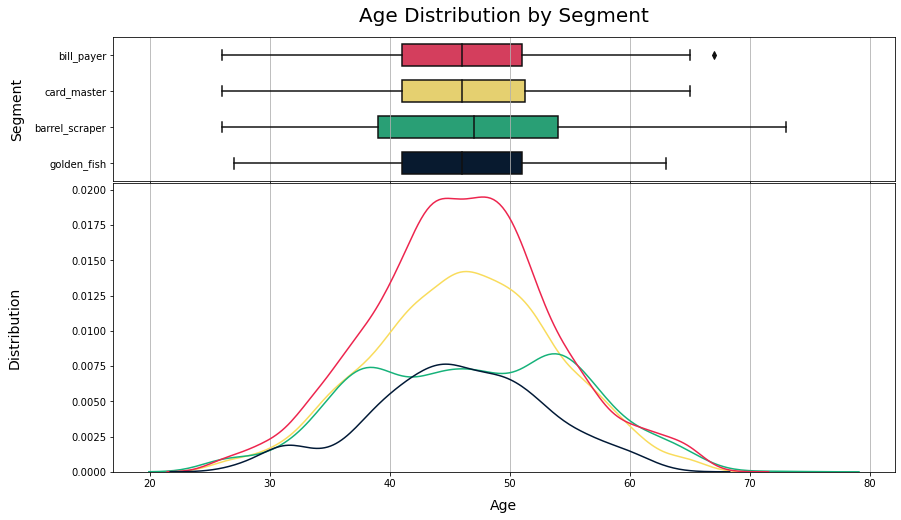

In [14]:

# Setup subplots
fig, (ax1, ax2) = plt.subplots(figsize=(14, 8), nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 2]})

# Plot the  horizontal boxes
box = sns.boxplot(data=client_df, x="age", y="segment", 
                  order = ['bill_payer', 'card_master', 'barrel_scraper', 'golden_fish'],
                  palette={'bill_payer':'#ED254E','card_master':'#F9DC5C','barrel_scraper':'#16b27a','golden_fish':'#011936'},
                  width=.6, ax=ax1
                 )

# Plot the distribution line
kde = sns.kdeplot(data=client_df, x="age", hue="segment", 
                  palette={'bill_payer':'#ED254E','card_master':'#F9DC5C','barrel_scraper':'#16b27a','golden_fish':'#011936'}, 
                  ax=ax2
                 )
# setup boxplot
box.xaxis.grid(True)
box.set(xlabel='')
box.set_ylabel('Segment', fontsize=14, labelpad = 10)
box.set_title('Age Distribution by Segment', fontsize=20, pad=15)

# setup kdeplot
kde.xaxis.grid(True)
kde.set_ylabel('Distribution', fontsize=14, labelpad = 50)
kde.set_xlabel('Age', fontsize=14, labelpad = 10)
kde.get_legend().remove()

# setup figure
#fig.tight_layout()
fig.subplots_adjust(hspace=0.01)

We can see on the boxplot that for all the segments median and IQR ranges are comparable. The `Age` distribution further shows that there is no apparent way of guessing the `segment` of random sample based only on age.

***

# Sanity Model

Before building models, we should establish a way of checking if guesses made by classifierss are not random (or at least better than that). *Sanity check* in this notebook has two steps:
1. Model that makes random guesses
2. Model that always chooses the most common segment

Firstly, we will split the data (train-test split) in a stratified fashion.

In [15]:
from sklearn.model_selection import train_test_split

X = client_df.drop(['segment', 'client_id'],axis=1)
y = client_df[['segment']]

# define the 80_20 train_test splits 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    Model that makes random guesses

In [16]:
from sklearn.dummy import DummyClassifier

# defince classifier
random_dummy = DummyClassifier(strategy='stratified')

# make guesses at random
random_dummy.fit(X_train, y_train)

# print train and test score
print(f'Training score: {random_dummy.score(X_train,y_train)} \nTest score: {random_dummy.score(X_test,y_test)}')

Training score: 0.27987230161143206 
Test score: 0.27598784194528875


    Model that always chooses the most common segment

In [17]:
# defince classifier
dummy = DummyClassifier(strategy='most_frequent')

# make guesses with most frequent segment
dummy.fit(X_train, y_train)

# print train and test score
print(f'Training score: {dummy.score(X_train,y_train)} \nTest score: {dummy.score(X_test,y_test)}')

Training score: 0.37017330495591366 
Test score: 0.3702127659574468


>Model making guesses, where each class has stratified probability based on class representation in data set, scores around 28% accuracy. Model, that chooses most frequent segment, would score 37% accuracy.

> The **37% accuracy** score is going to be our starting **base value**.

# Classifiers

Before final model, let's consider basic decision tree classifier first, and how good scores can it get when tuned. In this chapter we will look into some techniqes of optimazing medel's hyperparameteres and problems that ML model can run into. One of the techniqes is using Pipelines for cross validation.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

### Data encoding 

But first we need to define manner, in which data will be encoded so that models can deal with it.

To encode columns/features we first need to import neceserry encoders and specify how to encode chosen features. Then we define `column_transformer` and all of the encoding is being done inside it.

Encoding strategy:
* categorical data - OneHotEncoder
* ordinal data - OrdinalEncoder
* age is discretized into 6 bins of uniform width

In [19]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, Normalizer, KBinsDiscretizer
from sklearn.compose import make_column_transformer

# column lists
bin_columns = ['age']
numerical_columns = ['dependent_count']
ordinal_columns = ['education_level', 'income_category']
ordinal_categories = [['Unknown','Uneducated','High School', 'College','Graduate', 'Post-Graduate', 'Doctorate'],
                      ['Unknown', 'Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +']]
categorical_columns = ['gender', 'marital_status']

#create encoder objects
ohe = OneHotEncoder(sparse=False, drop='if_binary')
oe = OrdinalEncoder(categories=ordinal_categories)
kbd = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='uniform')

#create column transformer
ct = make_column_transformer(    
    (ohe, categorical_columns),
    (oe, ordinal_columns),
    (kbd, numerical_columns),
    ('passthrough', numerical_columns),
    remainder = 'drop'
    );

### Evaluation strategy

The models are evaluated using StratifiedKFold, which means that in each fold class balance is preserved

In [20]:
from sklearn.model_selection import StratifiedKFold

# define the evaluation method
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## Decision tree classifier

### CART - naive model

Let's build basic decision tree model to check how well it performs without any tuning, pruning, feature selection or dimensionality reduction techniques.

In [21]:
from sklearn.tree import DecisionTreeClassifier

# defince classifier
dtc = DecisionTreeClassifier(random_state=42)

# create pipeline
dtc_pipe = Pipeline(
        [('ct', ct),
         ('tree', dtc)
        ])

# evaluate model
scores = cross_val_score(dtc_pipe, X_train, y_train, cv=cv, scoring='accuracy')

print(f'Decision tree accuracy: {scores.mean()*100}%')

Decision tree accuracy: 39.100128149967844%


The cart model scores around 39% accuracy. It is much better than random guessing, but only slighlty better than choosing most commont segment - 2% margin. This is not satisfing.

*** 

### CART - tuning the model using grid_search

Let's try pruning and tuning hyperparameters of the decision tree using `GridSearchCV`

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
# defince the model with default hyperparameters
dtc = DecisionTreeClassifier(random_state=42)
dtc_pipe = Pipeline(
        [('ct', ct),
         ('tree', dtc)
        ])

# define the grid of values to search
dtc_prune_grid = dict()
dtc_prune_grid['tree__ccp_alpha'] = [0.1, 0.01, 0.001, 0.0001] #np.arange(0.0008, 0.0013, step=0.0001)

# define the grid search procedure
dtc_prune_search = GridSearchCV(dtc_pipe, param_grid=dtc_prune_grid, cv=cv, scoring='accuracy', n_jobs=n_jobs)

# execute the grid search
dtc_prune_result = dtc_prune_search.fit(X_train, np.ravel(y_train));

# print the best score and configuration
print(f'Best acc: {dtc_prune_result.best_score_*100:.2f}% using {dtc_prune_result.best_params_}')

Best acc: 46.03% using {'tree__ccp_alpha': 0.001}


.

Pruned tree with ccp = 0.001 scores 46% (complexity parameter used for minimal most-complexity pruning). That is 9% better than dummy model and 7% better than basic tree.

***

    Is it possible to score better accuracy tuning other hyperparameters?

In [24]:
# define the grid of values to search
dtc_grid = dict()
dtc_grid['tree__max_depth'] = np.arange(2, 6, step=1)
dtc_grid['tree__min_samples_split'] = np.arange(10, 20, step=2)
dtc_grid['tree__min_samples_leaf'] = np.arange(10, 20, step=2)
dtc_grid['tree__max_features'] = ['sqrt', 'log2', None]

# define the grid search procedure
dtc_search = GridSearchCV(dtc_pipe, param_grid=dtc_grid, cv=cv, scoring='accuracy', n_jobs=n_jobs)

# execute the grid search
dtc_result = dtc_search.fit(X_train, np.ravel(y_train));

# print the best score and configuration
print(f'Best acc: {dtc_result.best_score_*100:.2f}% using {dtc_result.best_params_}')

Best acc: 46.03% using {'tree__max_depth': 3, 'tree__max_features': None, 'tree__min_samples_leaf': 10, 'tree__min_samples_split': 10}


> Both attempts score the same accuracy: 46.03%.

Yet, there is a pressing issue that needs to be adressed. We are using cross_validation strategy to prevent model from overfitting and predict classes on new data as well as possible. Still, it is important to take the issue into consideration and do some future proofing - also there are models that take very long time to fit and performing cross validation strategy is not vaiable then.

### CART - overfitting

It is important to take overfitting (or underfitting) of our algorithm into consideration - we have to be sure that our model does not memorize the data learning *by heart* and therefore performs worse on the new data set, which it has never seen before (so called bias/variance problem). 

Let's check the decision tree classifier. We will consider `max_depth` parameter. 

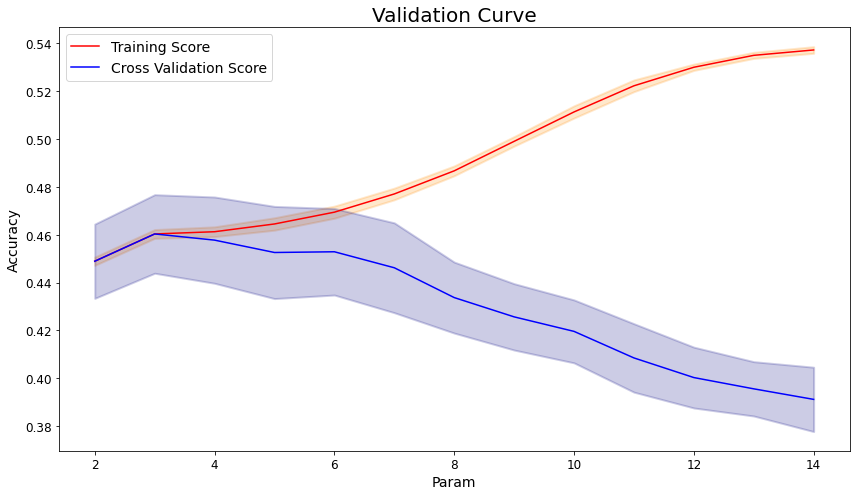

In [25]:
import visualbox as vs

# define model
model = Pipeline([('ct', ct),('tree', DecisionTreeClassifier(random_state=42))])

# define parameter to check
param_name = "tree__max_depth"
param_range = np.arange(2, 15, 1)

# plot validation curve
vs.plot_validation_curve(model, X_train, np.array(y_train).ravel(), param_name, param_range, cv)

Model is overfitting when the diffrence between training and validation lines is increasing. We can see that model is significantly overfitting when param (tree depth) is larger then 4. Therefore, `max_depth = 3` searched by GridSearch is a proper parameter.

# Final Model

The final model is the Stacking Ensemble. This model uses predictions from other classifiers as an input alongside training data to return final predicitions. The idea is: if we have a lot of estimators and each of them understands and classifies data diffrently, it may be worth to train *super estimator* to combine those predictions and increase the accuracy.

## Lower Level Classifiers

Let's have a look at lower level classifiers that pass predicitons to meta model. 

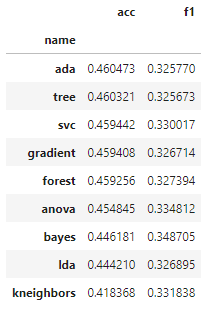

In the above table there are scores that models achieved in conducted experiments (Classification[test] notebook - TBA). Let's have a closer look what is actually in the table.

**F1-score** is a measure of model's performance, it is calculacted from the precision and recall of the test (harmonic mean). Precision can be stated as within everything that has been predicted as a positive, precision counts the percentage that is correct. Recall can be stated as within everything that actually is positive, how many did the model succeed to find. Ideally, we would want both: a model that identifies all of our positive cases at the same time only positive ones. Unfortunately, we have to deal with the so-called Precision-Recall Trade-Off. F1-score lets us choose the model that combines recall and precision in the best way.

> For the grid searched models F1 score is quite similar. GradientBoost is the worst in both metrics - 45.85% accuracy, 0.3226 F1. AdaBoost is slightly better then RandomForest in accuracy (ada: 46.04% vs. rfc: 45.92%) and worse in F1 score (rfc:0.3267 vs. ada:0.3258).

**Random Forest and boosters** Those algoirthms share some similarities,eg. base model `Decision Tree`:

* **Random Forest** creates a lot of tree estimators that are trained on diffrent parts of the data and often apply bootstraping strategy.
* **AdaBoost** creates a forest of stumps (tree of depth = 1). Single stump is awful at predicting anything, but applying diffrent weights to the whole forest of them creates a valid classifiaction model.
* **GradientBoost** is an additive model in a forward stage-wise fashion, it creates next tree based on residuals of the former. In other words the algorithm uses an arbitrary loss function to create new estimators.

**Nearest Neighbours** Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.

**Naive Bayes** methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. We are going to use **CategoricalNB**, implements the categorical naive Bayes algorithm (which generalizes Bernoulli distributions) for categorically distributed data. It assumes that each feature has its own categorical distribution - or in other words *ordinally encoded*. [[source]](https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes) 

**SVC** - Support Vector (Machine) Classifier. SVM maps training examples to points in space so as to maximise the width of the gap between the categories. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall.

**ANOVA** is an acronym for “analysis of variance” and is a parametric statistical hypothesis test for determining whether the means from two or more samples of data (often three or more) come from the same distribution or not. Here it used as **feature selecion method** before the base classifier **dedcision tree**.

**LDA** stands for Linear Discriminant Analysis, which is a **dimensionality reduction** technique. Unsurprisingly *decision tree* trained after LDA doesn't achieve the best score as there is not a lot of features in our dataset. Yet, it is included in this section as it might have learned diffrent features then the rest of the models.

### Define Estimators

In this section we are going to define estimators that were chosen to create Stacking Ensemble

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# definy voting classifier using anova feature selection
def get_anova():
    model_list = list()
    # enumerate the features in the training dataset
    for i in range(2, 6):
        # create the feature selection transform
        fs = SelectKBest(score_func=f_classif, k=i)
        # create the model
        model = DecisionTreeClassifier(random_state=42)
        # create the pipeline
        pipe = Pipeline([('fs',fs), ('m', model)])
        # add as a tuple to the list of models for voting
        model_list.append((str(i),pipe))
    # define the voting ensemble
    ensemble = VotingClassifier(estimators=model_list, voting='hard')
    return ensemble

# return estimators
def get_models():
    models = dict()
    models['tree'] = DecisionTreeClassifier(ccp_alpha=0.001, random_state=42)
    models['forest'] = RandomForestClassifier(max_depth=4, n_estimators=200, 
                                              min_samples_split=20, random_state=42)
    models['ada'] = AdaBoostClassifier(learning_rate=0.1, n_estimators=50, 
                                       random_state=42)
    models['gradient'] = HistGradientBoostingClassifier(max_leaf_nodes=8, max_iter=100, 
                                                        learning_rate=0.01, l2_regularization=0.05)
    models['bayes'] = CategoricalNB()
    models['kneighbors'] = KNeighborsClassifier(metric='manhattan', n_neighbors=17, weights='uniform')
    models['svc'] = SVC(kernel='rbf', gamma='scale', C = 10,
                        decision_function_shape= 'ovo', random_state=42)
    models['anova'] = get_anova()
    models['lda'] = Pipeline([('lda', LinearDiscriminantAnalysis(n_components=2)),
                              ('m', DecisionTreeClassifier(ccp_alpha=0.001))])
    
    return models

    and evaluate defined models.

>tree 0.460 (0.016)
>forest 0.459 (0.016)
>ada 0.460 (0.017)
>gradient 0.459 (0.016)
>bayes 0.446 (0.018)
>kneighbors 0.418 (0.018)
>svc 0.461 (0.016)
>anova 0.455 (0.017)
>lda 0.419 (0.021)


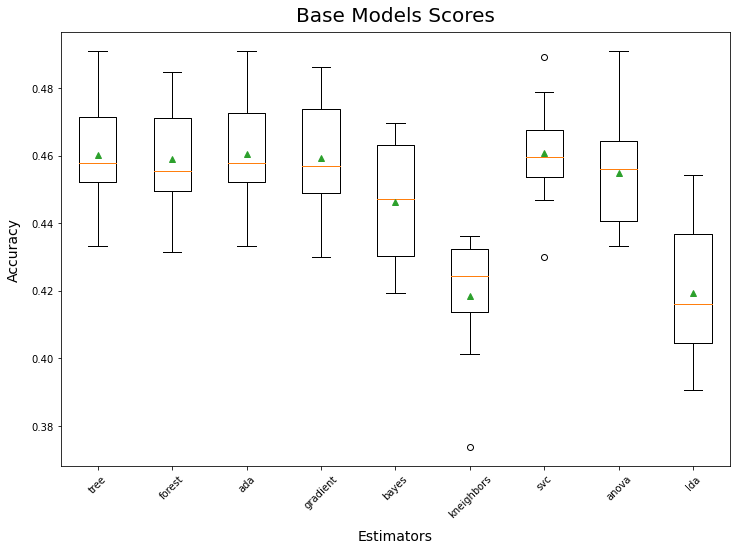

In [27]:
# evaluate a given model using cross-validation
def evaluate_model(model, cv, X, y):
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=n_jobs, error_score='raise')
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, cv, ct.fit_transform(X_train), y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

# plot model performance for comparison
plt.subplots(figsize=(12, 8));
plt.boxplot(results, labels=names, showmeans=True);
plt.title('Base Models Scores', fontsize=20, pad=10)
plt.xlabel('Estimators', fontsize = 14, labelpad=10)
plt.ylabel('Accuracy', fontsize = 14, labelpad=10)
plt.xticks(rotation = 45);

The tree based methods (tree, random forest, adaboost, gradient boosting) achieve similar results. The least accurate predicitions are made by kneighbors classifier. Support Vector Machine is the most accurate on evaluation.

***

## Stacking Ensemble Classifier

It uses a meta-learning algorithm to learn how to best combine the predictions from two or more base machine learning algorithms. The benefit of stacking is that it can harness the capabilities of a range of well-performing models on a classification or regression task and make predictions that have better performance than any single model in the ensemble.

The meta-model is often simple, providing a smooth interpretation of the predictions made by the base models. As such, linear models are often used as the meta-model. 

>Classification Meta-Model: Logistic Regression.

The use of a simple linear model as the meta-model often gives stacking the colloquial name “blending.” As in the prediction is a weighted average or blending of the predictions made by the base models.

### Training

Final Stacking Model builds on four models chosen experimentally: `gradient`, `forest`, `svc`  and `lda`. (feel free to conduct further experimentes with code below)

Let's define the ensemble and evaluate it on training data.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    models = get_models()
    for model in ['gradient', 'forest', 'svc', 'lda']:
        level0.append((model, models[model]))
    # define meta learner model
    level1 = LogisticRegression(solver='liblinear')
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model


>tree 0.459 (0.015)
>forest 0.460 (0.015)
>ada 0.460 (0.014)
>gradient 0.460 (0.014)
>bayes 0.447 (0.019)
>kneighbors 0.418 (0.017)
>svc 0.461 (0.015)
>anova 0.455 (0.016)
>lda 0.419 (0.017)
>stacking 0.459 (0.018)


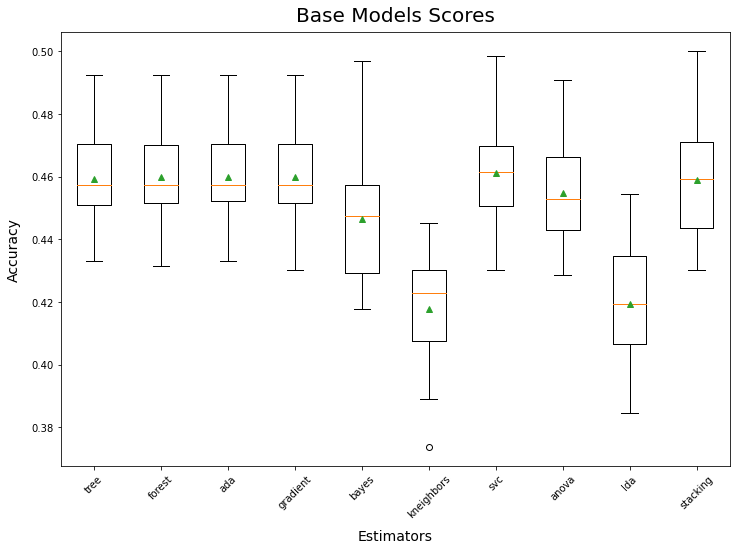

In [29]:
from sklearn.model_selection import RepeatedStratifiedKFold

# define new evaluation strategy to get more robust predictions
cv2 = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# get the models to evaluate
models = get_models()
models['stacking'] = get_stacking()
# evaluate the models and store results
results, names = list(), list()
eval_score = dict()
for name, model in models.items():
    scores = evaluate_model(model, cv2, ct.fit_transform(X_train), y_train)
    eval_score[name] = scores.mean()
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

# plot model performance for comparison
plt.subplots(figsize=(12, 8));
plt.boxplot(results, labels=names, showmeans=True);
plt.title('Base Models Scores', fontsize=20, pad=10)
plt.xlabel('Estimators', fontsize = 14, labelpad=10)
plt.ylabel('Accuracy', fontsize = 14, labelpad=10)
plt.xticks(rotation = 45);

As we can see in the above box plot Stacking Estimator achieves comparable accuracy scores to tree based models.

### Test data

After evaluating the Stacking Ensemble accuracy, we should also check how does model perform on testing data when trained on all of training data. 

In [30]:
from sklearn import metrics

# get the models to evaluate
models = get_models()
models['stacking'] = get_stacking()
# evaluate the models and store results
f1, acc, names = list(), list(), list()
for name, model in models.items():
    y_hat = model.fit(ct.fit_transform(X_train), np.ravel(y_train)).predict(ct.fit_transform(X_test))
    f1s = (metrics.f1_score(np.ravel(y_test), y_hat, average = 'macro'))
    accs = (metrics.accuracy_score(np.ravel(y_test), y_hat))
    f1.append(f1s)
    acc.append(accs)
    names.append(name)
    print(f'acc:{accs*100:.2f}\tf1:{f1s:.3f}\t{name}')

acc:45.41	f1:0.315	tree
acc:45.71	f1:0.322	forest
acc:45.35	f1:0.313	ada
acc:45.59	f1:0.319	gradient
acc:44.01	f1:0.345	bayes
acc:41.46	f1:0.333	kneighbors
acc:45.59	f1:0.324	svc
acc:45.35	f1:0.336	anova
acc:42.49	f1:0.313	lda
acc:45.47	f1:0.330	stacking


>The Stacking CLassifier scores second in Accuracy with 45.65%. F1 score 0.332 for this model is better then random forest's, which scored best in accuracy. Therefore chosen stacking model is a the best middle ground between the number of accurate predictions and the quality of predicitions.

### Confusion Matrices

In this notebook, the last step in determining whether a model is worth anything is the confusion matrix, which plots the predictions against the true values.

Below we define three confusion matrices: Stacking Ensemble (Estimator Confusion Matrix), model that always chooses the most common segment (Dummy Confusion Matrix) and model that makes random guess based on segment distribution (Stratified Confusion Matrix).

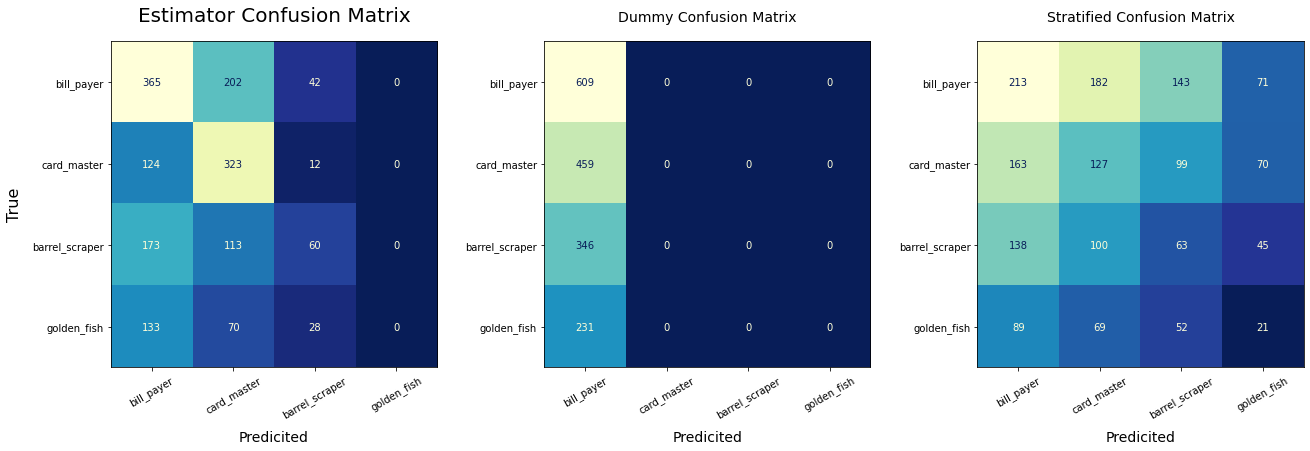

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# define stacking pipeline
stacking = get_stacking()
stack_pipe = Pipeline([('ct', ct),
                       ('stack', stacking)])

# fit stacking
stack_pipe.fit(X_train, np.ravel(y_train))

# define labels
labels = y_test['segment'].unique()


# setup figure
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(22, 6), ncols=3)

# plot stacking estimator confusion matrix
ConfusionMatrixDisplay.from_estimator(stack_pipe, X_test, y_test, labels=labels, 
                                      xticks_rotation=30, colorbar = False, ax=ax1, cmap='YlGnBu_r')
ax1.set_title('Estimator Confusion Matrix', fontsize=20, pad=20)
ax1.set_xlabel('Predicited', fontsize = 14, labelpad=10)
ax1.set_ylabel('True', fontsize = 16, labelpad=10)

# plot dummy model confusion matrix
ConfusionMatrixDisplay.from_estimator(dummy, X_test, y_test, labels=labels, 
                                      xticks_rotation=30, colorbar = False, ax=ax2, cmap='YlGnBu_r')
ax2.set_title('Dummy Confusion Matrix', fontsize=14, pad=20)
ax2.set_xlabel('Predicited', fontsize = 14, labelpad=10)
ax2.set_ylabel('')

#plot stratified dummy confusion matrix
ConfusionMatrixDisplay.from_estimator(random_dummy, X_test, y_test, 
                                      labels=labels, xticks_rotation=30, colorbar = False, ax=ax3, cmap='YlGnBu_r')
ax3.set_title('Stratified Confusion Matrix', fontsize=14, pad=20)
ax3.set_xlabel('Predicited', fontsize = 14, labelpad=10)
ax3.set_ylabel('');

Dummy classifier doesn't recognize any other segment than bill_payer, which is most common, as expected. Estimator correctly predicted most of the samples in two segments: `bill_payer` - 60% and `card_master` - 70% precision (barrel_scraper 18%, golden_fish 0%). Yet the model does poor job recognizing `barrel_scraper` and doesn't predict `golden_fish` at all. 

This is bad news for our classifier as it cannot be used to classify all the clients a priori (before collecting bank statistics). However, it is quite precise when prediciting the segments `bill_payer` and `card_master`, which account for over 60% of all current clients - there is some hope.

# Summary

The goal of this part of the project was to create model that is be able to classify clients to marketing segments based only the demographic data. The problem turned out to be very challenging. 

Segments where created based on only statisitics collected by company, so there was no certainty that clusters will be distinguishable in new domain (demographic data). When inspecting segments in the EDA chapter, the only clearly stanidng out group was `card_master`. This was not a promising omen.

Machine Learning algorithm that was finally chosen is the Stacking Ensemble Classifier, which combines outcomes from other classifiers to return final predicitons. Stacking Classifier achieved 45.65% accuracy on testing data and 0.33 f1 score. These metrics show that our model is better than random guesses, but they also suggest that the predictions are of questionable quality. Therefore, confusion matrices where definied to check how model deals with each class. The model has high precision for two segments `bill_payer` and `card_master`, but it fails to predict `golden_fish` and `barrel_scraper`. 

# What now?

This outcome leads to two major conclusions:
* the model is not reliable enough to be used as a classifier for all of the segments,
* enginner has to be very carefull when evaluating the model, as one metric doesn't paint the whole picture - the accuracy can be high, but the model fails to recognize one class.

    
    What does it mean for the project? 

The easiest way forward is to assume that **it was a failure**. On the other hand, based in the confusion matrices we clearly see that the model does good job of predicting two segments, this fact opens up a diffrent path. The other way is to take advantage of what **our model is good** at. 

    How so?
    
We have to admit that the model is not good for its assumed purpose: "classify all new clients into marketing segments based on the demographic data". However, if we change the task slightly: "assign a new customer to marketing segments based on demographics *if justified*". Then we can try to use our classifier's strengths to predict the `bill_payer` and `card_master` segments. This can be done, among others with a filter in front of the model. If the new customer's demographic information is close to one of the two segments, the classifier makes a prediciton, but if the data does not pass the filter, no prediciton is made.

    Is it the end?

The next decision to make is whether or not a new use case is desired. I will accept the new scenario.  At the beginning, I wanted to use the model prediction to create a contract recommendation system for new clients that would support the company's employee. Now the plan has changed, the system will only suggest personalized offers to the company's employee if the client fits one of the two segments.